In [43]:
# Import signal
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

# Import sim functions
from neurodsp.sim.combined import sim_combined, sim_peak_oscillation
from neurodsp.sim.aperiodic import sim_powerlaw
from neurodsp.utils import set_random_seed

# Import function to compute power spectra
from neurodsp.spectral import compute_spectrum

# Import utilities for plotting data
from neurodsp.utils import create_times
from neurodsp.plts.spectral import plot_power_spectra
from neurodsp.plts.time_series import plot_time_series


In [44]:
# Set some general settings, to be used across all simulations
num_signals = 1
fs = 2000 #sampling 주파수
n_seconds = 2 #simulation 지속시간
times = create_times(n_seconds, fs) #시간 백터

# Define the components of the combined signal to simulate
n_neurons_range = (800, 1200)  # range for number of neurons
firing_rate_range = (2, 4)     # range for firing rate
t_ker_range = (0.8, 1.2)       # range for t_ker
tau_r_range = (0.001, 0.003)   # range for tau_r
tau_d_range = (0.015, 0.025)   # range for tau_d
freq_range = (15, 25)          # range for oscillation frequency
amplitude_range = (17,18)   # range for amplitude_range

# Sample values from the specified ranges
n_neurons = np.random.randint(n_neurons_range[0], n_neurons_range[1] + 1)
firing_rate = np.random.uniform(firing_rate_range[0], firing_rate_range[1])
t_ker = np.random.uniform(t_ker_range[0], t_ker_range[1])
tau_r = np.random.uniform(tau_r_range[0], tau_r_range[1])
tau_d = np.random.uniform(tau_d_range[0], tau_d_range[1])
freq = np.random.uniform(freq_range[0], freq_range[1])


In [45]:
# 초기 (0, 4000) 크기의 빈 numpy 배열 생성
data_signal = np.empty((0, len(times)))
data_signal_with_artifact = np.empty((0, len(times)))
data_artifact = np.empty((0, len(times)))

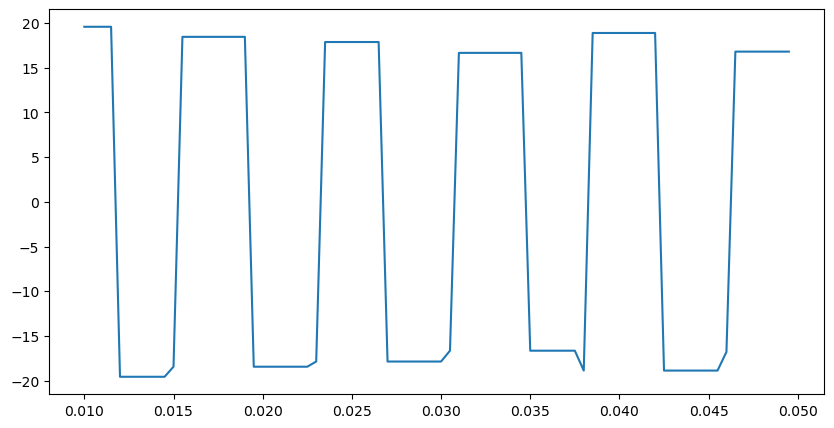

In [46]:
for idx in range(num_signals):
    components = {
        'sim_synaptic_current': {
        'n_neurons': n_neurons,
        'firing_rate': firing_rate,
        't_ker': t_ker,
        'tau_r': tau_r,
        'tau_d': tau_d
        },
        'sim_oscillation': {
        'freq': freq
        }
    }
    # Simulate an oscillation over an aperiodic component
    signal = sim_combined(n_seconds, fs, components)
    
    # Generate artifact
    
    amplitude = np.random.uniform(amplitude_range[0], amplitude_range[1])
    t = np.arange(0, n_seconds, 1/fs)
    frequency = 130
    period = 1/frequency
    num_cycles = int(np.ceil(t[-1] / period))
    
    # Generate a 130 Hz sine wave
    sine_wave = amplitude * np.sin(2 * np.pi * frequency * t)
    
    # Generate randomly varying amplitude sine wave
    # 재현성을 위해 시드 설정
    np.random.seed(0)  
    random_amplitudes = np.random.uniform(amplitude-5, amplitude+5, num_cycles)
    sine_wave_varying = np.zeros_like(t)
    for i in range(num_cycles):
        start_idx = int(i * period * len(t) / t[-1])
        end_idx = int((i + 1) * period * len(t) / t[-1])
        sine_wave_varying[start_idx:end_idx] = random_amplitudes[i] * np.sin(2 * np.pi * frequency * t[start_idx:end_idx])
    

    # Generate a 130 Hz triangle wave 
    triangle_wave = amplitude * 2 * np.abs(2 * (t * frequency - np.floor(t * frequency + 0.5))) - amplitude
   
    # Generate randomly varying amplitude triangle wave
    np.random.seed(0)  
    random_amplitudes = np.random.uniform(amplitude-5, amplitude+5, num_cycles)
    triangle_wave_varying = np.zeros_like(t)
    for i in range(num_cycles):
        start_idx = int(i * period * len(t) / t[-1])
        end_idx = int((i + 1) * period * len(t) / t[-1])
        cycle_t = t[start_idx:end_idx]
        cycle_wave = random_amplitudes[i] * 2 * np.abs(2 * (cycle_t * frequency - np.floor(cycle_t * frequency + 0.5))) - random_amplitudes[i]
        triangle_wave_varying[start_idx:end_idx] = cycle_wave[:end_idx - start_idx]
         #  확대할 구간 설정
    
    # Generate a 130 Hz square wave 
    square_wave = amplitude * np.sign(np.sin(2 * np.pi * frequency* t))

    # Generate randomly varying amplitude square wave
    # 재현성을 위해 시드 설정
    np.random.seed(0)  
    random_amplitudes = np.random.uniform(amplitude-5, amplitude+5, num_cycles)
    square_wave_varying = np.zeros_like(t)
    for i in range(num_cycles):
        start_idx = int(i * period * len(t) / t[-1])
        end_idx = int((i + 1) * period * len(t) / t[-1])
        cycle_t = t[start_idx:end_idx]
        cycle_wave =  random_amplitudes[i] * np.sign(np.sin(2 * np.pi * frequency* cycle_t))
        square_wave_varying[start_idx:end_idx] = cycle_wave[:end_idx - start_idx]
    
     #  확대할 구간 설정
    start_time = 0.01
    end_time = 0.05
    start_idx = np.searchsorted(t, start_time)
    end_idx = np.searchsorted(t, end_time)

    #그래프 그리기 (확대된 구간)
    plt.figure(figsize=(10, 5))
    plt.plot(t[start_idx:end_idx], square_wave_varying[start_idx:end_idx], label='Randomly Modulated Amplitude per Cycle Sine Wave') 
    

    # Add the sine wave to the simulated signal
    artifact = square_wave
    signal_with_sine = signal + artifact
    
    # Add the signal as a new raw in the numpy array
    data_signal = np.vstack((data_signal, signal))
    data_signal_with_artifact = np.vstack((data_signal_with_artifact, signal_with_sine))
    data_artifact = np.vstack((data_artifact, artifact))


In [47]:
# data_signal의 shape 확인
print(data_signal.shape)
print(data_signal_with_artifact.shape)
print(data_artifact.shape)

(1, 4000)
(1, 4000)
(1, 4000)


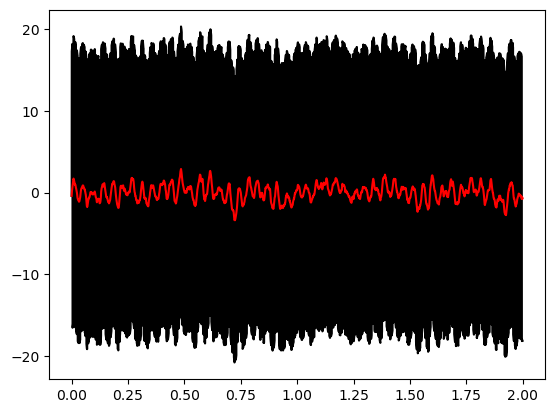

In [48]:
# Plot the first simulated signal
plt.figure()
plt.plot(times, data_signal_with_artifact[0, :],'k')
plt.plot(times, data_signal[0, :],'r')

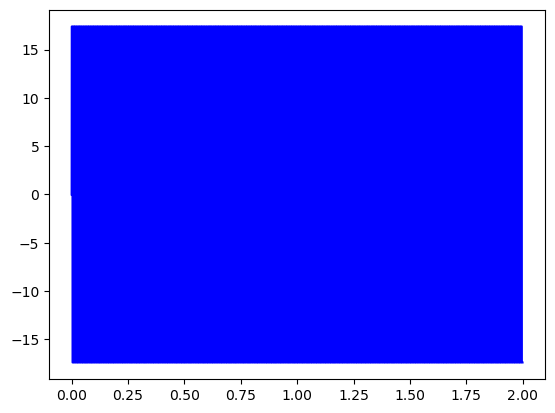

In [49]:
plt.plot(times, data_artifact[0,:], 'b')

In [50]:
#fpath = "./"

#np.save(fpath + "data_signal" + ".npy", data_signal)
#np.save(fpath + "data_artifact" + ".npy", data_artifact)
#np.save(fpath + "data_signal_with_artifact" + ".npy", data_signal_with_artifact)

In [51]:
# example for loading data

#data_signal = np.load(fpath + "data_signal" + ".npy")
#data_sine_wave = np.load(fpath + "data_artifact" + ".npy")
#data_signal_with_sine = np.load(fpath + "data_signal_with_artifact" + ".npy")

#plt.plot(data_signal[0, :])
